In [469]:
import datetime
import yfinance as yf  
import matplotlib.pyplot as plt  
import pandas as pd  
import numpy as np

In [483]:
start_date = "2013-01-01"
end_date = '2023-01-01'

levered_etf = "3USL.L" # 'UPRO'
benchmark = '^GSPC'

# levered_etf = "QQQ3.L"
# benchmark = 'EQQQ.DE'

window_size = 200 # days
starting_capital = 2500
trans = 3
interest_rate = 0.0275 / 251

In [484]:
# Calculate new start date
start_date_dt = datetime.datetime.strptime(start_date, "%Y-%m-%d")
adj_start_date = np.busday_offset(start_date_dt.date(), -window_size, roll='backward').astype(str)

In [485]:
data_sp500 = yf.download(benchmark, start=adj_start_date)["Close"]
data_etf = yf.download(levered_etf, start=adj_start_date)["Close"]
data = pd.concat([data_sp500, data_etf], axis=1).fillna(method="ffill")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [488]:
def determine_positions(data, benchmark, strategy="default"):
    """
    default:    MA < value: pos = 0
                MA >= value: pos = 1
    default:    MA < value: pos = 0
                MA >= value: pos = 1
                Position remains the same for 2 days when MA is breached
    """
    if strategy == "default":
        data['Position'] = (data[benchmark].squeeze() > data['MA']).astype(int)

    elif strategy == "default_lag":
        data['Position'] = (
            (data[benchmark].squeeze() > data['MA']).astype(int)
            .shift(1)
            .fillna(0)
            .astype(int)
        )

    elif strategy == "ls_lag":
        data['Position'] = (
            (data[benchmark].squeeze() > data['MA']).astype(int)
            .shift(1)
            .fillna(0)
            .astype(int)
            .replace(0, -1)
        )
    
    elif strategy == "buffer":
        data["Position"] = None  

        # Start with previous position as 0 (or you can modify it based on your needs)
        previous_position = 0  

        for i in range(len(data)):  
            if previous_position == 1 and data[benchmark].iloc[i] < 0.99 * data["MA"].iloc[i]:  
                previous_position = 0  # Switch to 0 when crossing below buffer  
            elif previous_position == 0 and data[benchmark].iloc[i] > 1.00 * data["MA"].iloc[i]:  
                previous_position = 1  # Switch to 1 when crossing above buffer  
            
            data.loc[data.index[i], "Position"] = previous_position

        data['Position'] = data['Position'].shift(1).fillna(0).astype(int)

    elif strategy == "default_sticky":
        def apply_stickiness(positions):  
            final_positions = [0] * len(positions)  
            current_position = 0
        
            for i in range(1, len(positions)):  
                if positions[i] == positions[i-1]:
                    current_position = positions[i]
                final_positions[i] = current_position
                  
            return final_positions
        
        data['Position'] = (
            (data[benchmark].squeeze() > data['MA']).astype(int)
            .shift(1)
            .fillna(0)
            .astype(int)
        )
        data['Position'] = apply_stickiness(data['Position'].to_list())
    

    elif strategy == "default_short":
        pass
    
    return data

In [489]:
# Calculate the 200-day moving average for the S&P 500
data['MA'] = data[benchmark].rolling(window=window_size).mean()
data['MA Short'] = data[benchmark].rolling(window=50).mean()
data = data.dropna()
  
data[f'Daily Return {benchmark}'] = data[benchmark].pct_change()
data[f'Daily Return {levered_etf}'] = data[levered_etf].pct_change()


strategy = "default_lag"
# data = determine_positions(data, benchmark, strategy="default_lag")
data = determine_positions(data, benchmark, strategy=strategy)
# data = determine_positions(data, benchmark, strategy="ls_lag")

# Returns without transaction costs
data["Harvested Return"] = data['Position'] * data[f'Daily Return {levered_etf}']
data["Portfolio Value"] = starting_capital * (1 + data["Harvested Return"]).cumprod()
data["Benchmark Value"] = starting_capital * (1 + data[f'Daily Return {benchmark}']).cumprod()
data["Lev. ETF Value"] = starting_capital * (1 + data[f'Daily Return {levered_etf}']).cumprod()

In [490]:
col_name = "Portfolio Value Trans"
data[col_name] = starting_capital
data["Transaction Flag"] = 0
previous_position = data['Position'].iloc[0]  
  
for i in range(1, len(data)):  
    current_position = data['Position'].iloc[i]  
    if current_position != previous_position:  
        # Apply transaction cost  
        data[col_name].iloc[i] = data[col_name].iloc[i-1] * (1 + data["Harvested Return"].iloc[i]) * (1 - 0.002) - 1
        data["Transaction Flag"].iloc[i] = 1
    elif current_position == 0:
        # Apply interest rate when in cash
        data[col_name].iloc[i] = data[col_name].iloc[i-1] * (1 + interest_rate)
    else:  
        data[col_name].iloc[i] = data[col_name].iloc[i-1] * (1 + data["Harvested Return"].iloc[i])  
    previous_position = current_position

/var/folders/wl/q_t1l4qj6dj7nq71tkhgc6v80000gn/T/ipykernel_82164/3420079712.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name].iloc[i] = data[col_name].iloc[i-1] * (1 + data["Harvested Return"].iloc[i]) * (1 - 0.002) - 1
/var/folders/wl/q_t1l4qj6dj7nq71tkhgc6v80000gn/T/ipykernel_82164/3420079712.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Transaction Flag"].iloc[i] = 1
/var/folders/wl/q_t1l4qj6dj7nq71tkhgc6v80000gn/T/ipykernel_82164/3420079712.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

In [491]:
data["Transaction Flag"].sum()

75

<Axes: xlabel='Date'>

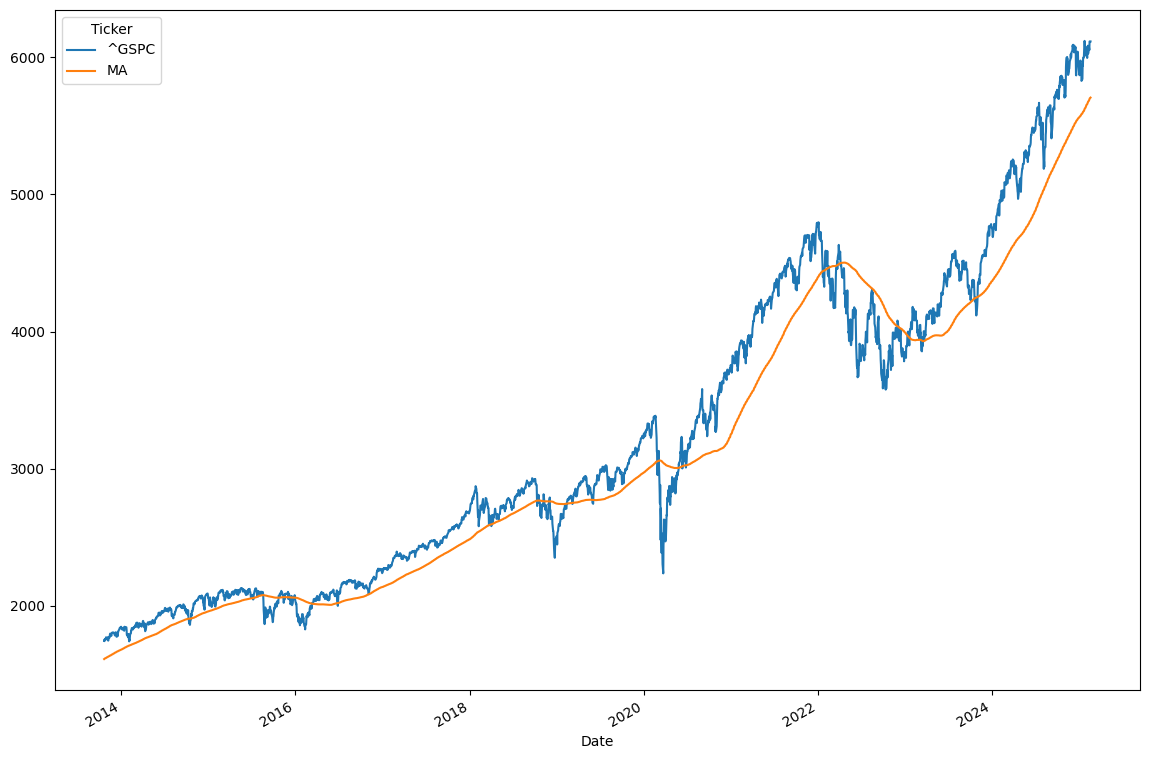

In [492]:
data[[f"{benchmark}", "MA"]].plot(figsize=(14,10))

In [493]:
data["Ratio"] = data["Portfolio Value Trans"] / data["Lev. ETF Value"]
data["Ratio_bench"] = data["Portfolio Value Trans"] / data["Benchmark Value"]

(0.0, 10.0)

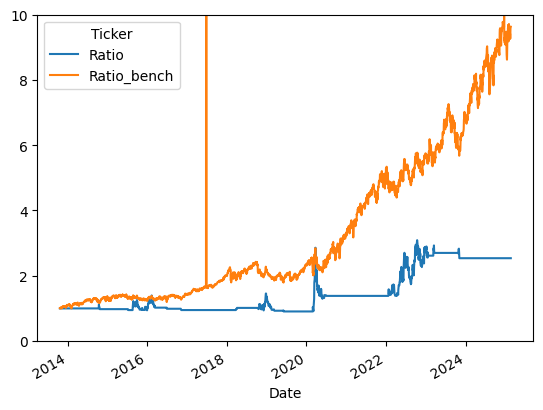

In [495]:
data[["Ratio", "Ratio_bench"]].plot()
plt.ylim([0,10])

Ticker,Portfolio Value,Portfolio Value Trans,Benchmark Value,Lev. ETF Value
Date,,,,
2025-02-11,36.494504,32.744112,3.478328,12.912332
2025-02-12,35.805301,32.125736,3.468854,12.668481
2025-02-13,36.860971,33.072919,3.505021,13.041994
2025-02-14,37.406903,33.562747,3.504769,13.235153
2025-02-17,37.602956,33.738653,3.504769,13.304520


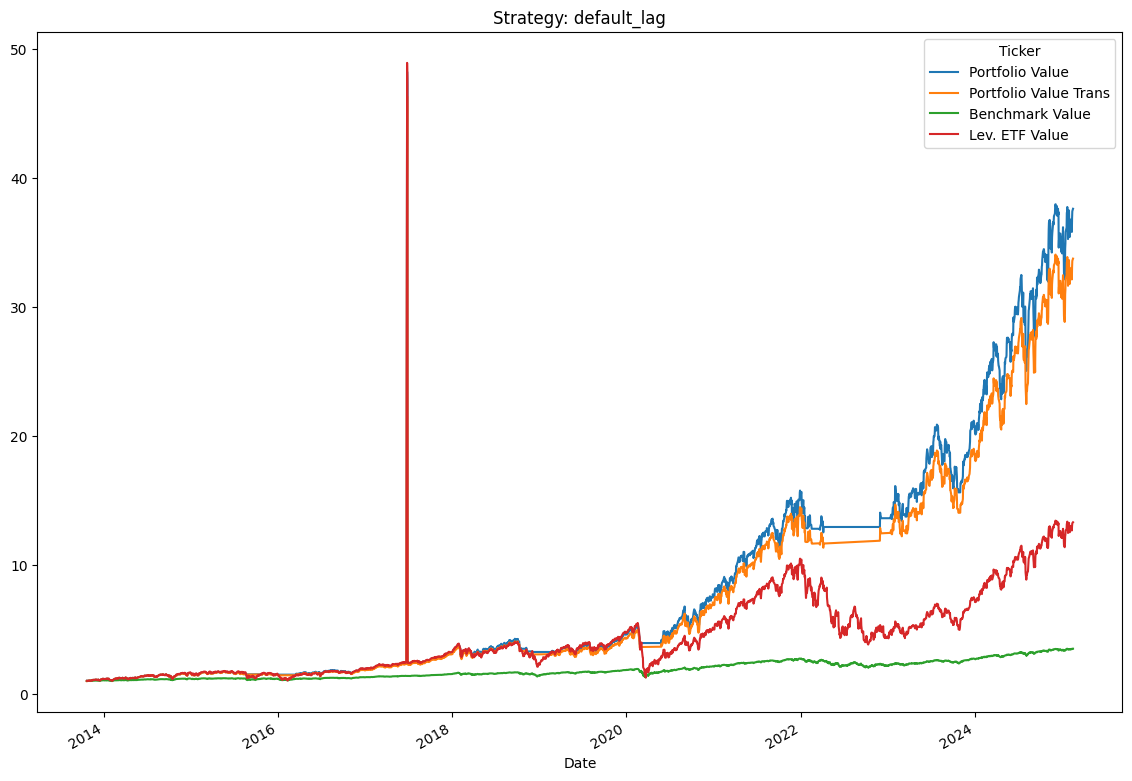

In [497]:
data_reidx = data[["Portfolio Value", "Portfolio Value Trans", "Benchmark Value", "Lev. ETF Value"]] / starting_capital
data_reidx.plot(figsize=(14,10))
plt.title(f"Strategy: {strategy}")
# plt.ylim([0,3])
data_reidx.tail(5)

Ticker,Portfolio Value,Portfolio Value Trans,Benchmark Value,Lev. ETF Value
Date,,,,
2025-02-11,36.494504,32.744112,3.478328,12.912332
2025-02-12,35.805301,32.125736,3.468854,12.668481
2025-02-13,36.860971,33.072919,3.505021,13.041994
2025-02-14,37.406903,33.562747,3.504769,13.235153
2025-02-17,37.602956,33.738653,3.504769,13.304520


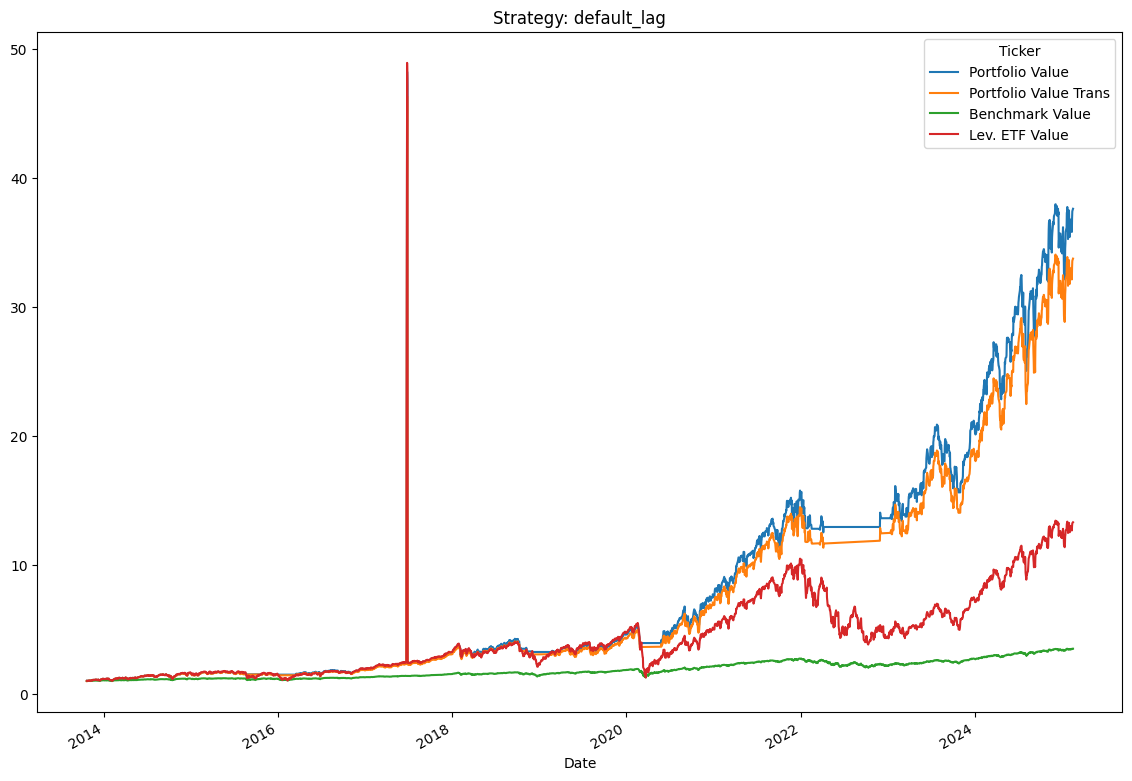

In [496]:
data_reidx = data[["Portfolio Value", "Portfolio Value Trans", "Benchmark Value", "Lev. ETF Value"]] / starting_capital
data_reidx.plot(figsize=(14,10))
plt.title(f"Strategy: {strategy}")
# plt.ylim([0,3])
data_reidx.tail(5)